In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oil-spill/label_colors.txt
/kaggle/input/oil-spill/val/images/Oil (741).jpg
/kaggle/input/oil-spill/val/images/Oil (1056).jpg
/kaggle/input/oil-spill/val/images/Oil (604).jpg
/kaggle/input/oil-spill/val/images/Oil (1173).jpg
/kaggle/input/oil-spill/val/images/Oil (908).jpg
/kaggle/input/oil-spill/val/images/Oil (42).jpg
/kaggle/input/oil-spill/val/images/Oil (403).jpg
/kaggle/input/oil-spill/val/images/Oil (279).jpg
/kaggle/input/oil-spill/val/images/Oil (114).jpg
/kaggle/input/oil-spill/val/images/Oil (704).jpg
/kaggle/input/oil-spill/val/images/Oil (195).jpg
/kaggle/input/oil-spill/val/images/Oil (479).jpg
/kaggle/input/oil-spill/val/images/Oil (901).jpg
/kaggle/input/oil-spill/val/images/Oil (863).jpg
/kaggle/input/oil-spill/val/images/Oil (641).jpg
/kaggle/input/oil-spill/val/images/Oil (1245).jpg
/kaggle/input/oil-spill/val/images/Oil (1172).jpg
/kaggle/input/oil-spill/val/images/Oil (578).jpg
/kaggle/input/oil-spill/val/images/Oil (75).jpg
/kaggle/input/oil-spill/va

In [5]:
import os

print(os.listdir("/kaggle/input"))


['oil-spill']


Find the correct path

In [6]:
import os

# List main folder contents
print(os.listdir("/kaggle/input/oil-spill"))

# List training images
print(os.listdir("/kaggle/input/oil-spill/train/images")[:5])  # show first 5 images

# List training masks
print(os.listdir("/kaggle/input/oil-spill/train/masks")[:5])


['val', 'test', 'label_colors.txt', 'train']
['Oil (1043).jpg', 'Oil (402).jpg', 'Oil (141).jpg', 'Oil (85).jpg', 'Oil (137).jpg']
['Oil (384).png', 'Oil (431).png', 'Oil (1238).png', 'Oil (939).png', 'Oil (557).png']


check inside to confirm the exact subfolders

In [7]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ===== 1. Dataset Class =====
class SARDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir))
        if mask_dir:
            self.masks = sorted(os.listdir(mask_dir))
        else:
            self.masks = None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Read image in grayscale (SAR images often single-channel)
        img_path = os.path.join(self.img_dir, self.images[idx])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = np.expand_dims(img, axis=-1)

        # Speckle noise reduction (simple Gaussian blur for now)
        img = cv2.GaussianBlur(img, (3,3), 0)

        # Normalize to [0,1]
        img = img / 255.0

        if self.mask_dir:
            mask_path = os.path.join(self.mask_dir, self.masks[idx])
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)

            if self.transform:
                augmented = self.transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
            return img, mask
        else:
            if self.transform:
                augmented = self.transform(image=img)
                img = augmented['image']
            return img

# ===== 2. Transformations / Augmentation =====
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    ToTensorV2()
])

# ===== 3. Load Datasets =====
train_img_dir = '/kaggle/input/oil-spill/train/images'
train_mask_dir = '/kaggle/input/oil-spill/train/masks'

val_img_dir = '/kaggle/input/oil-spill/val/images'
val_mask_dir = '/kaggle/input/oil-spill/val/masks'

train_dataset = SARDataset(img_dir=train_img_dir, mask_dir=train_mask_dir, transform=transform)
val_dataset = SARDataset(img_dir=val_img_dir, mask_dir=val_mask_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# ===== 4. Quick Check =====
for imgs, masks in train_loader:
    print("Images batch shape:", imgs.shape)
    print("Masks batch shape:", masks.shape)
    break


Images batch shape: torch.Size([8, 1, 256, 256])
Masks batch shape: torch.Size([8, 256, 256, 1])


Images and masks are resized, normalized, and augmented.

In [8]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ===== 1. Lee Filter Function =====
def lee_filter(img, size=5):
    """
    Apply Lee filter to reduce speckle noise in SAR images.
    img: 2D numpy array (grayscale)
    size: window size
    """
    img_mean = cv2.blur(img, (size, size))
    img_sqr_mean = cv2.blur(img**2, (size, size))
    img_var = img_sqr_mean - img_mean**2

    overall_var = np.var(img)
    # Avoid division by zero
    img_var = np.where(img_var == 0, 1e-8, img_var)

    img_filtered = img_mean + (img_var - overall_var) / img_var * (img - img_mean)
    return img_filtered

# ===== 2. Dataset Class =====
class SARDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir))
        if mask_dir:
            self.masks = sorted(os.listdir(mask_dir))
        else:
            self.masks = None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img = np.expand_dims(img, axis=-1)

        # Apply Lee filter
        img[:, :, 0] = lee_filter(img[:, :, 0], size=5)

        # Normalize to [0,1]
        img = img / 255.0

        if self.mask_dir:
            mask_path = os.path.join(self.mask_dir, self.masks[idx])
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)

            if self.transform:
                augmented = self.transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
            return img, mask
        else:
            if self.transform:
                augmented = self.transform(image=img)
                img = augmented['image']
            return img

# ===== 3. Transformations / Augmentation =====
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    ToTensorV2()
])

# ===== 4. Load Datasets =====
train_img_dir = '/kaggle/input/oil-spill/train/images'
train_mask_dir = '/kaggle/input/oil-spill/train/masks'

val_img_dir = '/kaggle/input/oil-spill/val/images'
val_mask_dir = '/kaggle/input/oil-spill/val/masks'

train_dataset = SARDataset(img_dir=train_img_dir, mask_dir=train_mask_dir, transform=transform)
val_dataset = SARDataset(img_dir=val_img_dir, mask_dir=val_mask_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# ===== 5. Quick Check =====
for imgs, masks in train_loader:
    print("Images batch shape:", imgs.shape)
    print("Masks batch shape:", masks.shape)
    break


Images batch shape: torch.Size([8, 1, 256, 256])
Masks batch shape: torch.Size([8, 256, 256, 1])


Lee filter replaces Gaussian blur → much better for SAR images.

Normalization, resizing, and augmentation are still applied.

In [6]:
train_img_dir = '/kaggle/input/oil-spill/train/images'
train_mask_dir = '/kaggle/input/oil-spill/train/masks'
val_img_dir = '/kaggle/input/oil-spill/val/images'
val_mask_dir = '/kaggle/input/oil-spill/val/masks'  give the step to write down in markdown

Define Training Image Directory,
Define Training Mask Directory,
Define Validation Image Directory,
Define Validation Mask Directory


In [8]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ===== Lee Filter Function =====
def lee_filter(img, size=5):
    img_mean = cv2.blur(img, (size, size))
    img_sqr_mean = cv2.blur(img**2, (size, size))
    img_var = img_sqr_mean - img_mean**2
    overall_var = np.var(img)
    img_var = np.where(img_var == 0, 1e-8, img_var)
    img_filtered = img_mean + (img_var - overall_var) / img_var * (img - img_mean)
    return img_filtered

# ===== SARDataset Class =====
class SARDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir))
        if mask_dir:
            self.masks = sorted(os.listdir(mask_dir))
        else:
            self.masks = None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img = lee_filter(img, size=5)
        img = img / 255.0
        img = np.expand_dims(img, axis=-1)

        if self.mask_dir:
            mask_path = os.path.join(self.mask_dir, self.masks[idx])
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)

            if self.transform:
                augmented = self.transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
                mask = mask.permute(2,0,1).float()
            else:
                img = torch.tensor(img).permute(2,0,1).float()
                mask = torch.tensor(mask).permute(2,0,1).float()
            return img, mask
        else:
            if self.transform:
                augmented = self.transform(image=img)
                img = augmented['image']
            else:
                img = torch.tensor(img).permute(2,0,1).float()
            return img


Import Required Libraries,Define Lee Filter Function,Create SARDataset Class,Initialize Dataset,Get Dataset Length,Load and Process Image,Load and Process Mask,Apply Augmentations,Convert to PyTorch Tensors,Return Image and Mask Pair

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    ToTensorV2()
])


In [11]:
train_img_dir = '/kaggle/input/oil-spill/train/images'
train_mask_dir = '/kaggle/input/oil-spill/train/masks'
val_img_dir = '/kaggle/input/oil-spill/val/images'
val_mask_dir = '/kaggle/input/oil-spill/val/masks'


In [12]:
from torch.utils.data import DataLoader

train_dataset = SARDataset(train_img_dir, train_mask_dir, transform=transform)
val_dataset = SARDataset(val_img_dir, val_mask_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [13]:
import torch
import torch.nn as nn

# ===== Double Convolution Block =====
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

# ===== U-Net Model =====
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_c=32):
        super().__init__()
        self.down1 = DoubleConv(in_channels, base_c)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base_c, base_c*2)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(base_c*2, base_c*4)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(base_c*4, base_c*8)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(base_c*8, base_c*16)
        self.up4 = nn.ConvTranspose2d(base_c*16, base_c*8, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(base_c*16, base_c*8)
        self.up3 = nn.ConvTranspose2d(base_c*8, base_c*4, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(base_c*8, base_c*4)
        self.up2 = nn.ConvTranspose2d(base_c*4, base_c*2, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(base_c*4, base_c*2)
        self.up1 = nn.ConvTranspose2d(base_c*2, base_c, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(base_c*2, base_c)
        self.out_conv = nn.Conv2d(base_c, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)
        d4 = self.down4(p3)
        p4 = self.pool4(d4)
        
        bn = self.bottleneck(p4)
        
        u4 = self.up4(bn)
        u4 = torch.cat([u4, d4], dim=1)
        d4 = self.dec4(u4)
        
        u3 = self.up3(d4)
        u3 = torch.cat([u3, d3], dim=1)
        d3 = self.dec3(u3)
        
        u2 = self.up2(d3)
        u2 = torch.cat([u2, d2], dim=1)
        d2 = self.dec2(u2)
        
        u1 = self.up1(d2)
        u1 = torch.cat([u1, d1], dim=1)
        d1 = self.dec1(u1)
        
        return self.out_conv(d1)


Import Required Libraries,Define Double Convolution Block,Define U-Net Architecture,Extract features using double conv blocks.

Downsample image via max pooling,

Capture high-level features in bottleneck,

Upsample with transpose convolutions and skip connections,

Output segmentation map with 1×1 convolution.

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# ===== Dice coefficient and loss =====
def dice_coef(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2.*intersection + smooth)/(pred.sum() + target.sum() + smooth)

class DiceLoss(nn.Module):
    def forward(self, pred, target):
        return 1 - dice_coef(pred, target)

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    def forward(self, pred, target):
        return self.bce(pred, target) + self.dice(pred, target)

# ===== Metrics =====
def iou_coef(pred, target, smooth=1e-5):
    pred = (torch.sigmoid(pred) > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef_metric(pred, target, smooth=1e-5):
    pred = (torch.sigmoid(pred) > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum()
    return (2.*intersection + smooth)/(pred.sum() + target.sum() + smooth)

# ===== Device, model, optimizer =====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, out_channels=1).to(device)
criterion = BCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 30

best_val_dice = 0

for epoch in range(num_epochs):
    # ===== Training =====
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        if masks.shape != outputs.shape:
            masks = masks.permute(0,3,1,2).float()  # [B,1,H,W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # ===== Validation =====
    model.eval()
    val_loss = 0
    val_iou = 0
    val_dice = 0
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            if masks.shape != outputs.shape:
                masks = masks.permute(0,3,1,2).float()
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_iou += iou_coef(preds, masks)
            val_dice += dice_coef_metric(preds, masks)

            all_preds.append(preds.cpu().numpy().flatten())
            all_masks.append(masks.cpu().numpy().flatten())

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_dice /= len(val_loader)

    # ===== Convert to integers for sklearn metrics =====
    all_preds = np.concatenate(all_preds).astype(np.int32)
    all_masks = np.concatenate(all_masks).astype(np.int32)

    acc = accuracy_score(all_masks, all_preds)
    prec = precision_score(all_masks, all_preds, zero_division=0)
    rec = recall_score(all_masks, all_preds, zero_division=0)
    f1 = f1_score(all_masks, all_preds, zero_division=0)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Dice: {val_dice:.4f} "
          f"Val IoU: {val_iou:.4f} "
          f"Acc: {acc:.4f} "
          f"Prec: {prec:.4f} "
          f"Recall: {rec:.4f} "
          f"F1: {f1:.4f}")

    # ===== Save best model =====
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), 'best_unet_model.pth')


Epoch [1/30] Train Loss: 1.0907 Val Loss: 1.0625 Val Dice: 0.6988 Val IoU: 0.5425 Acc: 0.1703 Prec: 0.0000 Recall: 0.0000 F1: 0.0000
Epoch [2/30] Train Loss: 1.0377 Val Loss: 1.0476 Val Dice: 0.7095 Val IoU: 0.5548 Acc: 0.1459 Prec: 0.0000 Recall: 0.0000 F1: 0.0000
Epoch [3/30] Train Loss: 1.0266 Val Loss: 1.0622 Val Dice: 0.7246 Val IoU: 0.5736 Acc: 0.0445 Prec: 0.0000 Recall: 0.0000 F1: 0.0000
Epoch [4/30] Train Loss: 1.0152 Val Loss: 1.0381 Val Dice: 0.7221 Val IoU: 0.5704 Acc: 0.1077 Prec: 0.0000 Recall: 0.0000 F1: 0.0000
Epoch [5/30] Train Loss: 1.0137 Val Loss: 1.0360 Val Dice: 0.7235 Val IoU: 0.5722 Acc: 0.1032 Prec: 0.0000 Recall: 0.0000 F1: 0.0000
Epoch [6/30] Train Loss: 1.0098 Val Loss: 1.0254 Val Dice: 0.7203 Val IoU: 0.5682 Acc: 0.1197 Prec: 0.0000 Recall: 0.0000 F1: 0.0000
Epoch [7/30] Train Loss: 1.0034 Val Loss: 1.0172 Val Dice: 0.7197 Val IoU: 0.5670 Acc: 0.1384 Prec: 0.0000 Recall: 0.0000 F1: 0.0000
Epoch [8/30] Train Loss: 0.9975 Val Loss: 1.0211 Val Dice: 0.7271 Val

Import Required Libraries,Define Dice Coefficient and Dice Loss,Define IoU Metric,Dice Metric for Evaluation,Setup Device, Model, Loss, Optimizer,Training Loop,Validation Loop,Compute Sklearn Metrics,Print Metrics,Save Best Model.

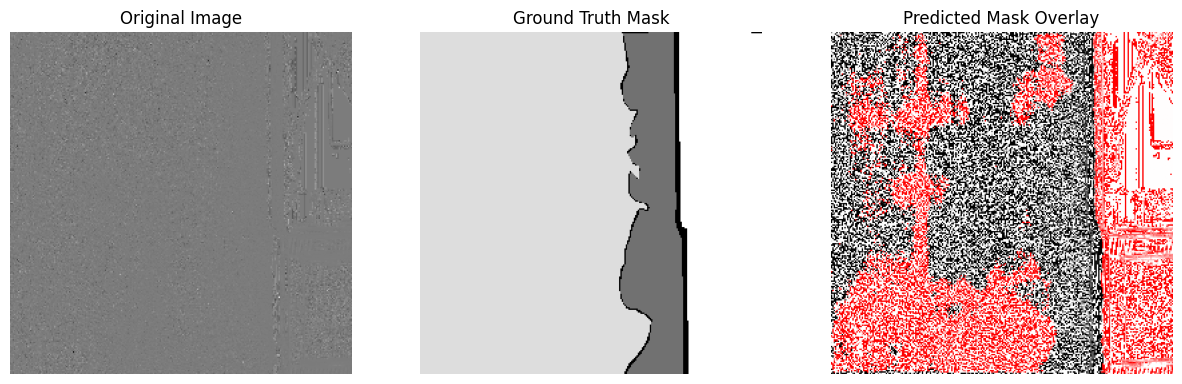

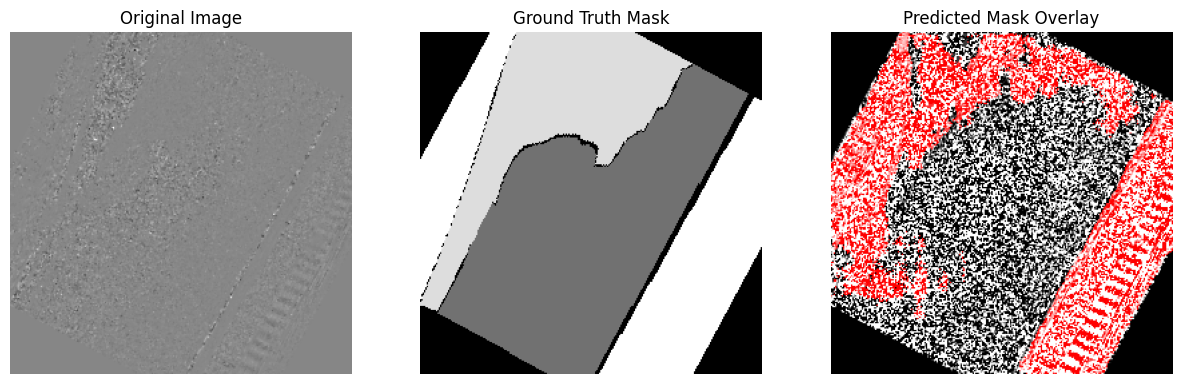

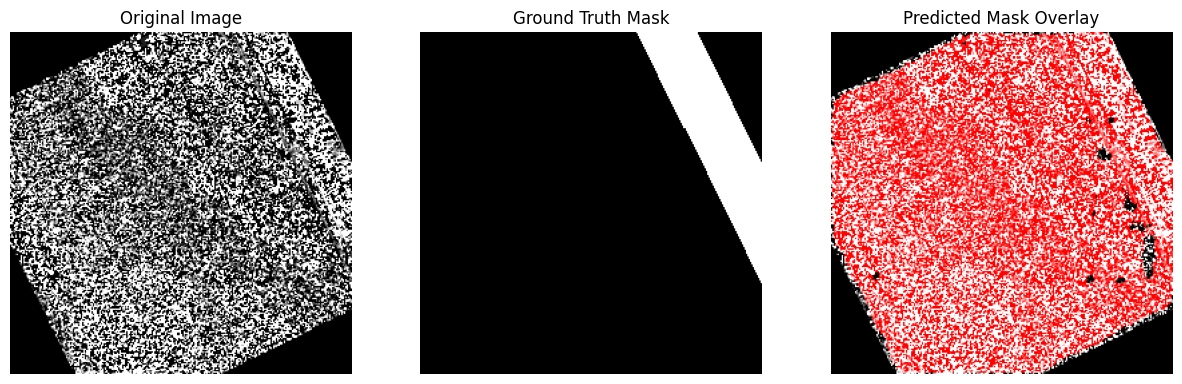

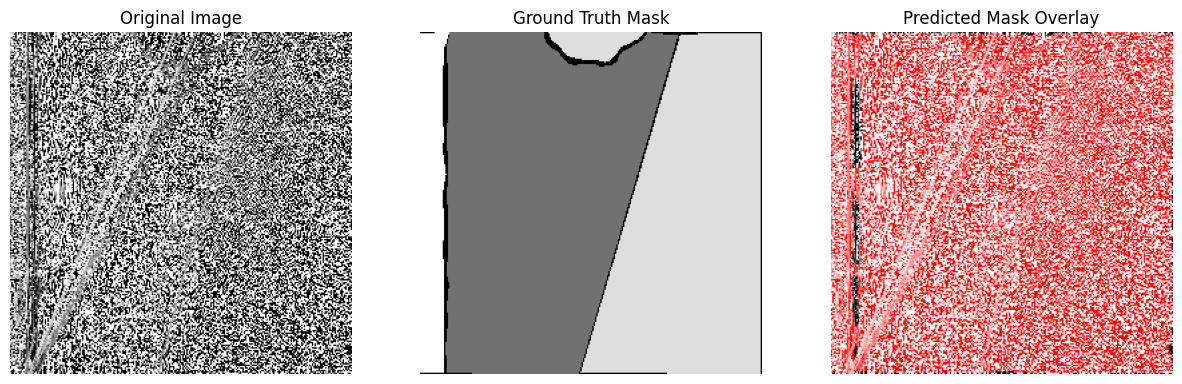

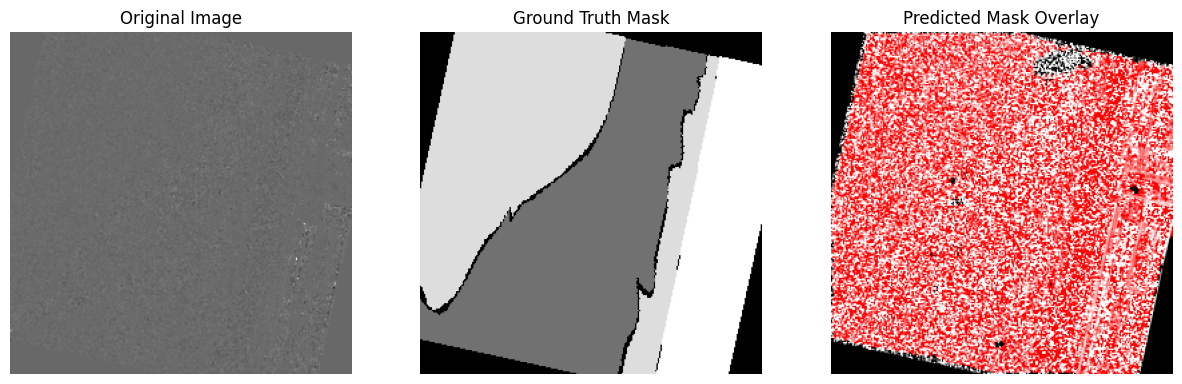

In [17]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Pick a few samples from validation set
model.eval()
num_samples = 5  # visualize 5 images
samples = iter(val_loader)

for i in range(num_samples):
    imgs, masks = next(samples)
    imgs, masks = imgs.to(device), masks.to(device)
    with torch.no_grad():
        outputs = model(imgs)
    
    for j in range(min(len(imgs), 1)):  # visualize 1 image per batch
        img = imgs[j].cpu().squeeze(0).numpy()        # [H,W]
        mask_gt = masks[j].cpu().squeeze(0).numpy()   # [H,W]
        mask_pred = (torch.sigmoid(outputs[j]) > 0.5).cpu().squeeze(0).numpy()  # [H,W]

        # Overlay predicted mask on original image
        overlay = np.stack([img, img, img], axis=-1)  # convert to RGB
        overlay[...,0] = np.maximum(overlay[...,0], mask_pred*1.0)  # Red channel

        # Plot side by side
        fig, ax = plt.subplots(1,3, figsize=(15,5))
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(mask_gt, cmap='gray')
        ax[1].set_title('Ground Truth Mask')
        ax[1].axis('off')

        ax[2].imshow(overlay)
        ax[2].set_title('Predicted Mask Overlay')
        ax[2].axis('off')

        plt.show()


In [ ]:
Import Required Libraries,Set Model to Evaluation Mode,Select Number of Samples to Visualize,Iterate Over Samples,Make Predictions,Process Each Image for Visualization,.
                                                                                                                                                     
Create Overlay of Prediction,Plot Original Image, Ground Truth, and Prediction,Pick samples from validation set.

Forward pass through model to get predictions.

Convert tensors to NumPy arrays and threshold predictions.

Create RGB overlay highlighting predicted mask.

Plot original image, ground truth mask, and overlay side by side.

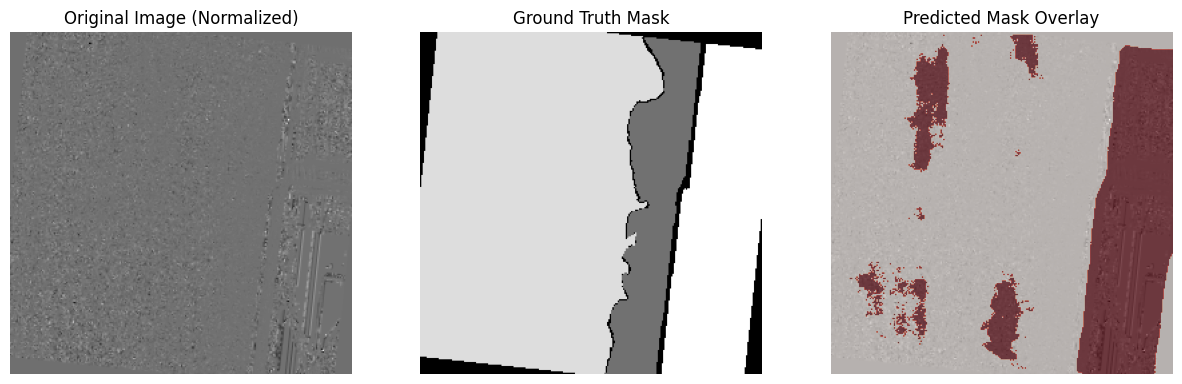

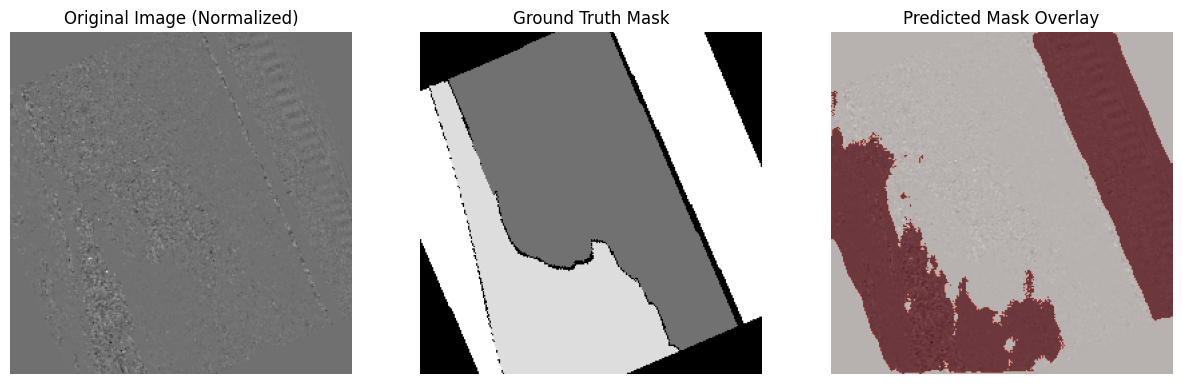

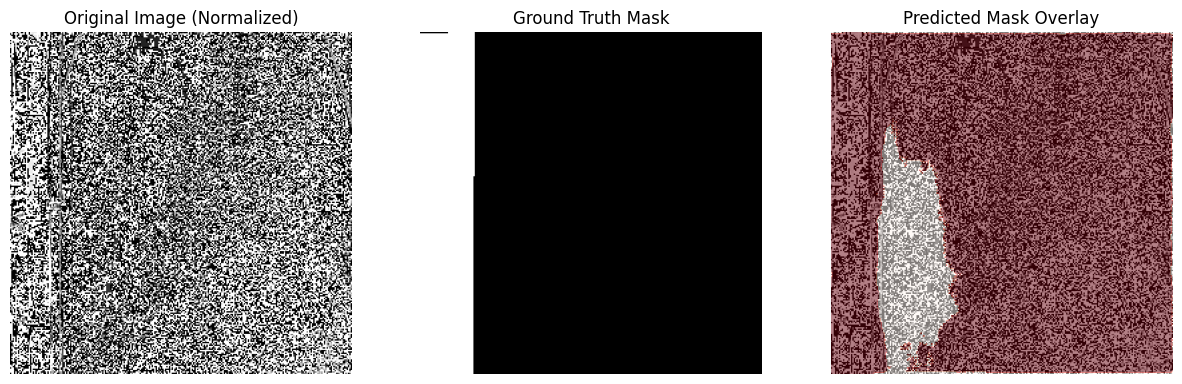

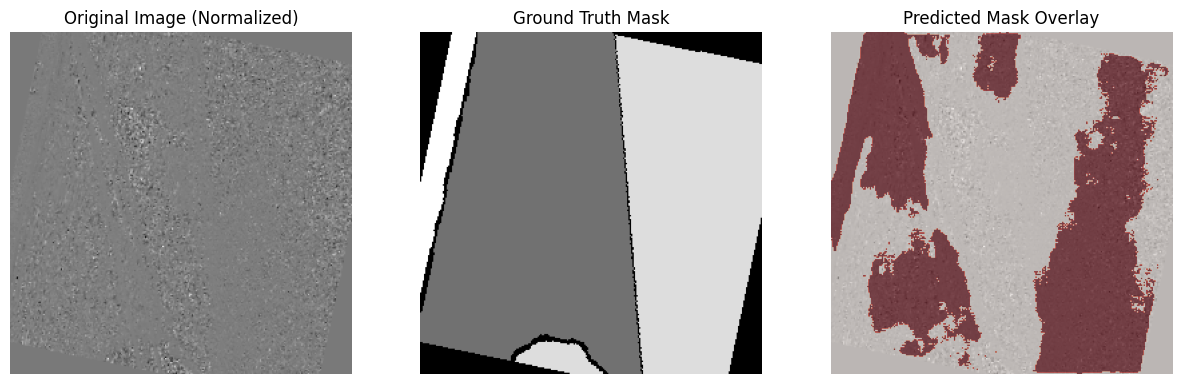

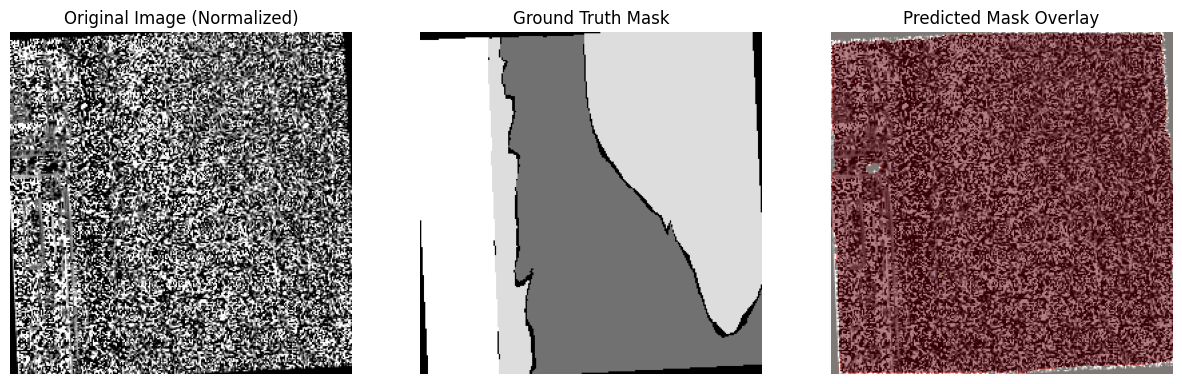

In [18]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Pick a few samples from validation set
model.eval()
num_samples = 5  # number of images to visualize
samples = iter(val_loader)

for i in range(num_samples):
    imgs, masks = next(samples)
    imgs, masks = imgs.to(device), masks.to(device)
    with torch.no_grad():
        outputs = model(imgs)
    
    for j in range(min(len(imgs), 1)):  # visualize 1 image per batch
        img = imgs[j].cpu().squeeze(0).numpy()        # [H,W]
        mask_gt = masks[j].cpu().squeeze(0).numpy()   # [H,W]
        mask_pred = (torch.sigmoid(outputs[j]) > 0.5).cpu().squeeze(0).numpy()  # [H,W]

        # Normalize image for better contrast
        img_disp = (img - img.min()) / (img.max() - img.min())

        # Overlay predicted mask in red with alpha
        overlay = np.stack([img_disp, img_disp, img_disp], axis=-1)  # convert to RGB
        overlay[...,0] = np.maximum(overlay[...,0], mask_pred*1.0)  # Red channel

        # Plot side by side
        fig, ax = plt.subplots(1,3, figsize=(15,5))

        ax[0].imshow(img_disp, cmap='gray')
        ax[0].set_title('Original Image (Normalized)')
        ax[0].axis('off')

        ax[1].imshow(mask_gt, cmap='gray')
        ax[1].set_title('Ground Truth Mask')
        ax[1].axis('off')

        ax[2].imshow(img_disp, cmap='gray')
        ax[2].imshow(mask_pred, cmap='Reds', alpha=0.5)  # semi-transparent overlay
        ax[2].set_title('Predicted Mask Overlay')
        ax[2].axis('off')

        plt.show()


Pick images from validation set.

Forward pass through model to get predictions.

Normalize images for contrast.

Convert tensors to NumPy arrays.

Overlay predicted mask in red (or semi-transparent).

Plot original image, ground truth, and predicted overlay side by side.

In [20]:
torch.save(model.state_dict(), 'unet_oilspill.pth')
